# CNNs for Image Classification

> *Deep Learning*  
> *MSc in Data Science, Department of Informatics*  
> *Athens University of Economics and Business*

---

#### *Description*

Given an image of a fashion item, build a deep learning model that recognizes the fashion item. You must use at least 2 different architectures, one with MLPs and one with CNNs. Use the Fashion-MNIST dataset to train and evaluate your models. More information about the task and the dataset can be found at <a href="https://github.com/zalandoresearch/fashion-mnist">https://github.com/zalandoresearch/fashion-mnist</a>. The dataset is also available from Tensorflow.

### 1. Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import gc
import tensorflow as tf
import keras
from tensorflow.keras import backend as K
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model  
from tensorflow.keras.layers import Input, Conv2D, Flatten, MaxPool2D
from tensorflow.keras.models import Model

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.13.0


### 2. Data

The Fashion-MNIST dataset is a collection of 70,000 images of clothing items, such as t-shirts, dresses, and shoes, each with a resolution of 28x28 pixels. It is commonly used as a benchmark dataset in machine learning and computer vision research, serving as a replacement for the traditional MNIST dataset of handwritten digits.</p>

The dataset was created by researchers at the Zalando Research group in 2017, with the aim of providing a more challenging and realistic dataset for image classification tasks. It has become a popular dataset for testing and comparing different machine learning algorithms, and has been used in a wide range of applications, such as object detection, image segmentation, and generative models.

In [2]:
# Load the Fashion-MNIST dataset in Train/Test
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print("\nThe x_train shape is:", x_train.shape)
print("The x_test shape is :", x_test.shape)


The x_train shape is: (60000, 28, 28)
The x_test shape is : (10000, 28, 28)


#### 2.1 Preprocess the data

- Normalize the values to [0, 255] --> [0, 1]  
- Convert target variables to categorical

In [3]:
# Preprocess the data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

### 3. Define Useful Functions

#### 3.1 Plot Functions

In [4]:
def print_results(hs, evaluate_model, metric='val_loss'):
    # Find the index and value of the minimum validation loss in the training history
    min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(hs.history[metric]))

    # Print information about the best epoch
    print('Best Epoch: ', idx + 1)
    print("---")

    # Print loss values
    print("Train Loss     : {0:.5f}".format(hs.history['loss'][idx]))
    print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][idx]))
    print("Test Loss      : {0:.5f}".format(evaluate_model[0]))
    print("---")

    # Print accuracy values
    print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][idx]))
    print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][idx]))
    print("Test Accuracy      : {0:.5f}".format(evaluate_model[1]))


def plot_history(hs, epochs, metric):
    # Print an empty line for better visual separation
    print()

    # Set the style and size of the plot
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [16, 8]
    plt.rcParams['font.size'] = 16

    # Clear the current plot
    plt.clf()

    # Iterate through each label in the history dictionary
    for label in hs:
        # Plot the training and validation metric values for each label
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
        
    # Set x-axis ticks at intervals of 10% of total epochs
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)

    # Set y-axis limit based on the metric being plotted
    plt.ylim((0, 1))

    # Set x-axis and y-axis labels
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric == 'loss' else 'Accuracy')

    # Display a legend
    plt.legend()

    # Show the plot
    plt.show()


def plot_cm(y_pred, y_test):
    # Convert predictions to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)
    # Convert test data to class labels
    y_test_classes = np.argmax(y_test, axis=1)

    # Create a confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    # Define the class names
    class_names = np.array(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

    # Plot the confusion matrix
    plt.rcParams['figure.figsize'] = [14, 10]
    sns.heatmap(cm, annot=True, fmt='d', cmap="crest", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

#### 3.2 Clean Function

In [5]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

## 4. Model Architectures (CNNs)

In this section we will create different architectures of a **Convolutional Neural Network**. We will focus especially on the number of hidden layers and the optimizers.

We will train all of our models in **100 epochs**. So, we will be able to plot how the model behaves. In case of overtraing we will use a callback to save the best weights. Then, we will use the model with best weights for evaluation and to make predictions.

#### 4.1 **CNN classifier 1 - Model 1**

> **Convolution layers:** One <br>
> **Dense layers:** One <br>
> **Activation function:** Relu and Softmax(output) <br>
> **Dropout:** 0.2 <br>
> **Loss function:** Categorical Cross Entropy <br>
> **Optimizer:** Adam - Learning Rate = 0.0002 <br>

##### 4.1.1 Creation

In [6]:
# Set seed for reproducibility
np.random.seed(99)
tf.random.set_seed(999)

# Create a sequential model
model = Sequential(name="Single_Layer_CNN")

# Define the optimizer
optimizer = Adam(learning_rate=0.0002)

# Define the input shape
input_shape = (28, 28, 1)

# Add the input layer to the model
model.add(Input(shape=input_shape, name='Input'))

# Add the convolutional layer
model.add(Conv2D(
    filters=8 * 2,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    dilation_rate=(1, 1),
    kernel_initializer='he_uniform',
    activation='relu',
    name='Conv2D-1'
))

# Add the max pooling layer
model.add(MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2),
    padding='same',
    name='MaxPool2D-1'
))

# Add dropout layer
model.add(Dropout(rate=0.2, name='Dropout-1'))

# Add flatten layer
model.add(Flatten(name='Flatten'))

# Add the output layer
model.add(Dense(units=10, activation='softmax', name='Output'))

# Display model summary
model.summary()

Model: "Single_Layer_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D-1 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 MaxPool2D-1 (MaxPooling2D)  (None, 14, 14, 16)        0         
                                                                 
 Dropout-1 (Dropout)         (None, 14, 14, 16)        0         
                                                                 
 Flatten (Flatten)           (None, 3136)              0         
                                                                 
 Output (Dense)              (None, 10)                31370     
                                                                 
Total params: 31,530
Trainable params: 31,530
Non-trainable params: 0
_________________________________________________________________


##### 4.1.2 Training

In [7]:
# Create callback to get the best weights after training
callbacks = [ModelCheckpoint(filepath='./Checkpoints/best_weights_Single_Layer_CNN.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True)]

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

hs = model.fit(
    x_train,
    y_train,
    batch_size=128,
    validation_split=0.1,
    epochs=100,
    verbose=1,
    callbacks=callbacks
    )

Epoch 1/100
422/422 [==============================] - 7s 15ms/step - loss: 0.7737 - accuracy: 0.7388 - val_loss: 0.4852 - val_accuracy: 0.8333
Epoch 2/100
422/422 [==============================] - 6s 15ms/step - loss: 0.4683 - accuracy: 0.8382 - val_loss: 0.4159 - val_accuracy: 0.8518
Epoch 3/100
422/422 [==============================] - 6s 14ms/step - loss: 0.4169 - accuracy: 0.8552 - val_loss: 0.3846 - val_accuracy: 0.8678
Epoch 4/100
422/422 [==============================] - 6s 14ms/step - loss: 0.3882 - accuracy: 0.8657 - val_loss: 0.3672 - val_accuracy: 0.8717
Epoch 5/100
422/422 [==============================] - 6s 14ms/step - loss: 0.3690 - accuracy: 0.8700 - val_loss: 0.3540 - val_accuracy: 0.8757
Epoch 6/100
422/422 [==============================] - 6s 13ms/step - loss: 0.3558 - accuracy: 0.8760 - val_loss: 0.3421 - val_accuracy: 0.8822
Epoch 7/100
422/422 [==============================] - 5s 13ms/step - loss: 0.3442 - accuracy: 0.8800 - val_loss: 0.3333 - val_accuracy:

422/422 [==============================] - 7s 16ms/step - loss: 0.2296 - accuracy: 0.9178 - val_loss: 0.2636 - val_accuracy: 0.9055
Epoch 58/100
422/422 [==============================] - 7s 16ms/step - loss: 0.2287 - accuracy: 0.9185 - val_loss: 0.2655 - val_accuracy: 0.9075
Epoch 59/100
422/422 [==============================] - 7s 17ms/step - loss: 0.2277 - accuracy: 0.9182 - val_loss: 0.2653 - val_accuracy: 0.9068
Epoch 60/100
422/422 [==============================] - 7s 17ms/step - loss: 0.2272 - accuracy: 0.9193 - val_loss: 0.2625 - val_accuracy: 0.9052
Epoch 61/100
422/422 [==============================] - 7s 17ms/step - loss: 0.2281 - accuracy: 0.9175 - val_loss: 0.2611 - val_accuracy: 0.9053
Epoch 62/100
422/422 [==============================] - 7s 16ms/step - loss: 0.2274 - accuracy: 0.9182 - val_loss: 0.2628 - val_accuracy: 0.9065
Epoch 63/100
422/422 [==============================] - 6s 15ms/step - loss: 0.2259 - accuracy: 0.9197 - val_loss: 0.2651 - val_accuracy: 0.904

##### 4.1.3 Evaluation

Best Epoch:  78
---
Train Loss     : 0.21670
Validation Loss: 0.25808
Test Loss      : 0.27402
---
Train Accuracy     : 0.92289
Validation Accuracy: 0.90817
Test Accuracy      : 0.90310



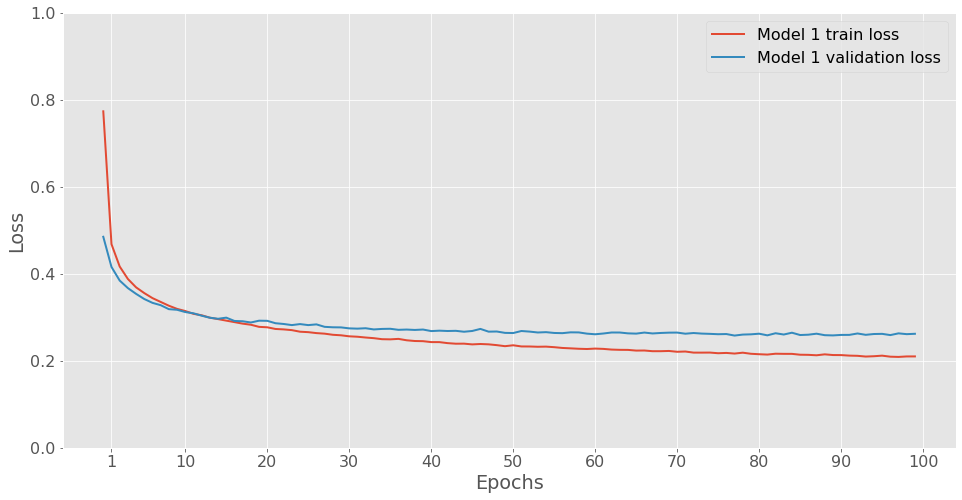

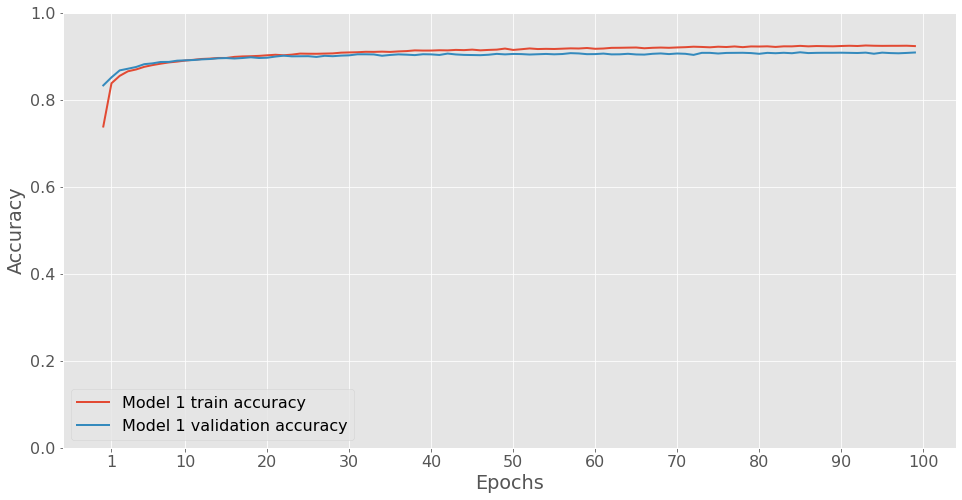

In [9]:
# Evaluate model with best weights on test data and show all the results.
score = model.evaluate(x_test, y_test, verbose=0)

# Print results
print_results(hs, score)

# Plot train and validation error per epoch.
plot_history(hs={'Model 1': hs}, epochs=100, metric='loss')
plot_history(hs={'Model 1': hs}, epochs=100, metric='accuracy')

##### 4.1.4 Predictions

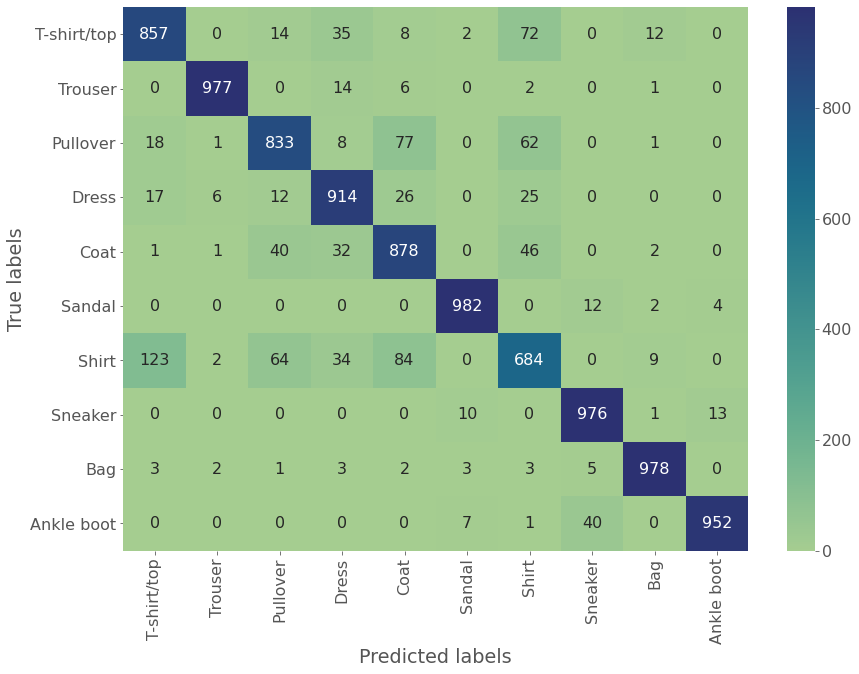

In [10]:
# Predict labels for test data
y_pred = model.predict(x_test, verbose = 0)

# Heatmap plot
plot_cm(y_pred, y_test)

# Delete model
clean_up(model)

##### *Remarks*

- In **epoch 78**, Model 1 achieves its lowest validation loss. However, as the training progresses, the model begins to exhibit signs of overfitting. We also note that the model converges relatively fast.

- The model attains an accuracy of **90.3%**. The heatmap visualization indicates that the majority of errors occur between Shirts and T-shirt/top, which aligns with our expectations.

#### 4.2 **CNN classifier 2 - Model 2**

> **Convolution layers:** Two <br>
> **Activation function:** Relu and Softmax(output) <br>
> **Dropout:** 0.2 <br>
> **Loss function:** Categorical Cross Entropy <br>
> **Optimizer:** Adam, Learning Rate = 0.0002 <br>

##### 4.2.1 Creation

In [10]:
# Set seed for reproducibility
np.random.seed(99)
tf.random.set_seed(999)

# Define the input shape
input_shape = (28, 28, 1)

# Create a sequential model
model_2 = Sequential(name="Two_Layer_CNN")

# Add the input layer to the model
model_2.add(Input(shape=input_shape, name='Input'))

# Add the first convolutional layer
model_2.add(Conv2D(
    filters=8 * 2,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    dilation_rate=(1, 1),
    kernel_initializer='glorot_uniform',  # GlorotUniform in sequential
    activation='relu',
    name='Conv2D-1'
))

# Add the first max pooling layer
model_2.add(MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2),
    padding='same',
    name='MaxPool2D-1'
))

# Add the first dropout layer
model_2.add(Dropout(rate=0.2, name='Dropout-1'))

# Add the second convolutional layer
model_2.add(Conv2D(
    filters=8 * 4,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    dilation_rate=(1, 1),
    kernel_initializer='glorot_uniform',  # GlorotUniform in sequential
    activation='relu',
    name='Conv2D-2'
))

# Add the second max pooling layer
model_2.add(MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2),
    padding='same',
    name='MaxPool2D-2'
))

# Add the second dropout layer
model_2.add(Dropout(rate=0.2, name='Dropout-2'))

# Add flatten layer
model_2.add(Flatten(name='Flatten'))

# Add the output layer
model_2.add(Dense(units=10, activation='softmax', name='Output'))

# Display model summary
model_2.summary()


Model: "Two_Layer_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D-1 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 MaxPool2D-1 (MaxPooling2D)  (None, 14, 14, 16)        0         
                                                                 
 Dropout-1 (Dropout)         (None, 14, 14, 16)        0         
                                                                 
 Conv2D-2 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 MaxPool2D-2 (MaxPooling2D)  (None, 7, 7, 32)          0         
                                                                 
 Dropout-2 (Dropout)         (None, 7, 7, 32)          0         
                                                                 
 Flatten (Flatten)           (None, 1568)            

##### 4.2.2 Training

In [17]:
callbacks = [ModelCheckpoint(filepath='./Checkpoints/best_weights_Second_CNN_Model.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True)]

optimizer = Adam(learning_rate = 0.0002)

model_2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

hs_2 = model_2.fit(
        x=x_train,
        y=y_train,
        validation_split=0.1,
        epochs=100,
        verbose=1,
        callbacks=[callbacks],
        batch_size=128
    )

Epoch 1/100
422/422 [==============================] - 10s 22ms/step - loss: 0.5175 - accuracy: 0.8131 - val_loss: 0.4638 - val_accuracy: 0.8400
Epoch 2/100
422/422 [==============================] - 9s 22ms/step - loss: 0.4882 - accuracy: 0.8247 - val_loss: 0.4465 - val_accuracy: 0.8433
Epoch 3/100
422/422 [==============================] - 10s 23ms/step - loss: 0.4689 - accuracy: 0.8340 - val_loss: 0.4255 - val_accuracy: 0.8513
Epoch 4/100
422/422 [==============================] - 10s 23ms/step - loss: 0.4520 - accuracy: 0.8379 - val_loss: 0.4076 - val_accuracy: 0.8590
Epoch 5/100
422/422 [==============================] - 10s 24ms/step - loss: 0.4328 - accuracy: 0.8464 - val_loss: 0.4047 - val_accuracy: 0.8600
Epoch 6/100
422/422 [==============================] - 10s 24ms/step - loss: 0.4214 - accuracy: 0.8502 - val_loss: 0.3893 - val_accuracy: 0.8622
Epoch 7/100
422/422 [==============================] - 10s 24ms/step - loss: 0.4111 - accuracy: 0.8550 - val_loss: 0.3798 - val_acc

##### 4.2.3 Evaluation

Best Epoch:  91
---
Train Loss     : 0.23875
Validation Loss: 0.23753
Test Loss      : 0.25408
---
Train Accuracy     : 0.91393
Validation Accuracy: 0.91567
Test Accuracy      : 0.90930



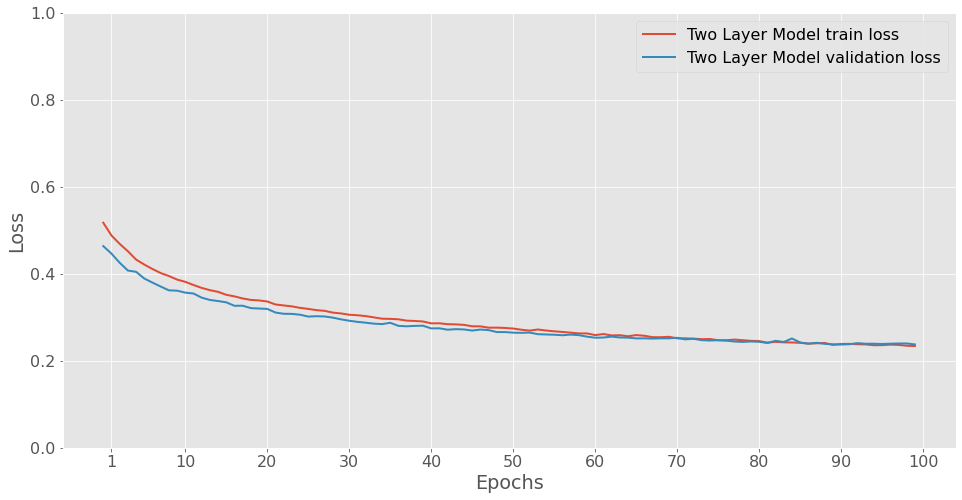

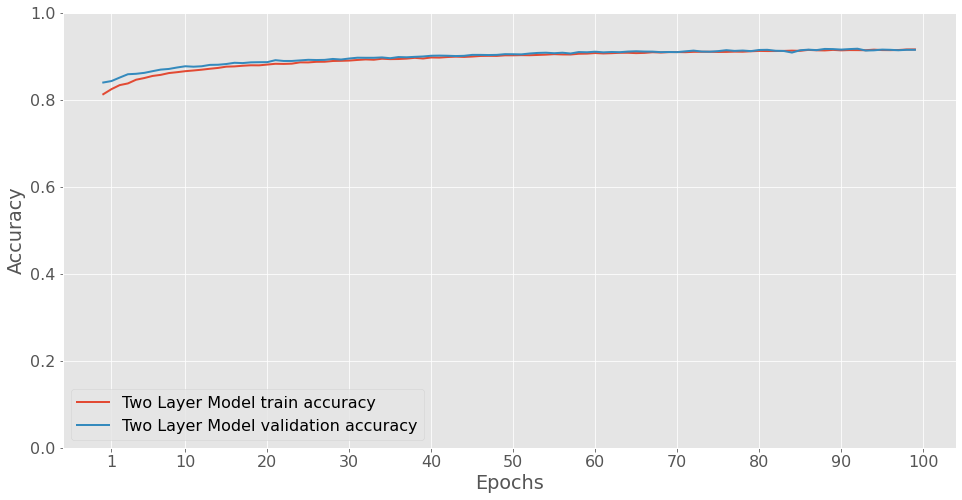

In [20]:
# Load the best weights
model_2.load_weights('./Checkpoints/best_weights_Second_CNN_Model.h5')

# Evaluate model with best weights on test data and show all the results.
score = model_2.evaluate(x_test, y_test, verbose=0)

# Print results
print_results(hs_2, score)

# Plot train and validation error per epoch.
plot_history(hs={'Two Layer Model': hs_2}, epochs=100, metric='loss')
plot_history(hs={'Two Layer Model': hs_2}, epochs=100, metric='accuracy')

##### 4.2.4 Predictions

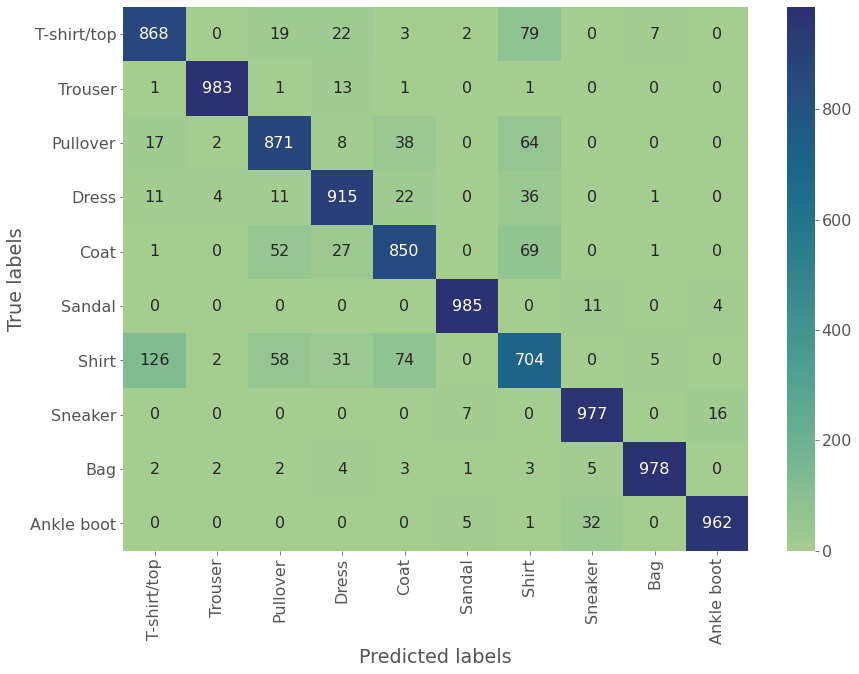

In [21]:
# Predict labels for test data
y_pred = model_2.predict(x_test, verbose = 0)

# Heatmap plot
plot_cm(y_pred, y_test)

# Delete model
clean_up(model_2)

##### *Remarks*

- In **epoch 91**, Model 2 achieves its lowest validation loss.

- Here, as training progresses, we do not see any evidence of overfitting. 

- The model achieves an accuracy of **90.9%**, which is higher than our first model. 

- He have managed to increase the true positives of shirts, but the confusion with the T-Shirts is not resolved

#### 4.3 **CNN classifier 3 - Model 3**

> **Convolution layers:** Three <br>
> **Activation function:** Relu and Softmax(output) <br>
> **Dropout:** 0.2 <br>
> **Loss function:** Categorical Cross Entropy <br>
> **Optimizer:** Adam, Learning Rate = 0.0002 <br>

##### 4.3.1 Creation

In [22]:
# Set seed for reproducibility
np.random.seed(99)
tf.random.set_seed(999)

# Define the input shape
input_shape = (28, 28, 1)

# Create a sequential model
model_3 = Sequential(name="Three_Layer_CNN")

# Add the input layer to the model
model_3.add(Input(shape=input_shape, name='Input'))

# Add the first convolutional layer
model_3.add(Conv2D(
    filters=8 * 2,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    dilation_rate=(1, 1),
    kernel_initializer='he_uniform',
    activation='relu',
    name='Conv2D-1'
))

# Add the first max pooling layer
model_3.add(MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2),
    padding='same',
    name='MaxPool2D-1'
))

# Add the first dropout layer
model_3.add(Dropout(rate=0.2, name='Dropout-1'))

# Add the second convolutional layer
model_3.add(Conv2D(
    filters=8 * 4,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    dilation_rate=(1, 1),
    kernel_initializer='glorot_uniform',
    activation='relu',
    name='Conv2D-2'
))

# Add the second max pooling layer
model_3.add(MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2),
    padding='same',
    name='MaxPool2D-2'
))

# Add the second dropout layer
model_3.add(Dropout(rate=0.2, name='Dropout-2'))

# Add the third convolutional layer
model_3.add(Conv2D(
    filters=8 * 8,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    dilation_rate=(1, 1),
    kernel_initializer='glorot_uniform',
    activation='relu',
    name='Conv2D-3'
))

# Add the third max pooling layer
model_3.add(MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2),
    padding='same',
    name='MaxPool2D-3'
))

# Add the third dropout layer
model_3.add(Dropout(rate=0.2, name='Dropout-3'))

# Add flatten layer
model_3.add(Flatten(name='Flatten'))

# Add the output layer
model_3.add(Dense(units=10, activation='softmax', name='Output'))

# Display model summary
model_3.summary()

Model: "Three_Layer_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D-1 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 MaxPool2D-1 (MaxPooling2D)  (None, 14, 14, 16)        0         
                                                                 
 Dropout-1 (Dropout)         (None, 14, 14, 16)        0         
                                                                 
 Conv2D-2 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 MaxPool2D-2 (MaxPooling2D)  (None, 7, 7, 32)          0         
                                                                 
 Dropout-2 (Dropout)         (None, 7, 7, 32)          0         
                                                                 
 Conv2D-3 (Conv2D)           (None, 7, 7, 64)      

##### 4.3.2 Training

In [23]:
callbacks = [ModelCheckpoint(filepath='./Checkpoints/best_weights_Third_CNN_Model.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True)]

optimizer = Adam(learning_rate = 0.0002)

model_3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

hs_3 = model_3.fit(
        x=x_train,
        y=y_train,
        validation_split=0.1,
        epochs=100,
        verbose=1,
        callbacks=[callbacks],
        batch_size=128
    )

Epoch 1/100
422/422 [==============================] - 12s 28ms/step - loss: 1.0816 - accuracy: 0.6067 - val_loss: 0.6196 - val_accuracy: 0.7773
Epoch 2/100
422/422 [==============================] - 11s 27ms/step - loss: 0.6371 - accuracy: 0.7651 - val_loss: 0.5077 - val_accuracy: 0.8167
Epoch 3/100
422/422 [==============================] - 11s 27ms/step - loss: 0.5463 - accuracy: 0.8012 - val_loss: 0.4503 - val_accuracy: 0.8378
Epoch 4/100
422/422 [==============================] - 12s 28ms/step - loss: 0.4949 - accuracy: 0.8186 - val_loss: 0.4131 - val_accuracy: 0.8535
Epoch 5/100
422/422 [==============================] - 12s 28ms/step - loss: 0.4596 - accuracy: 0.8342 - val_loss: 0.3904 - val_accuracy: 0.8618
Epoch 6/100
422/422 [==============================] - 12s 29ms/step - loss: 0.4354 - accuracy: 0.8424 - val_loss: 0.3692 - val_accuracy: 0.8700
Epoch 7/100
422/422 [==============================] - 12s 29ms/step - loss: 0.4135 - accuracy: 0.8512 - val_loss: 0.3565 - val_ac

##### 4.3.3 Evaluation

Best Epoch:  99
---
Train Loss     : 0.21017
Validation Loss: 0.20237
Test Loss      : 0.22360
---
Train Accuracy     : 0.92324
Validation Accuracy: 0.92483
Test Accuracy      : 0.92120



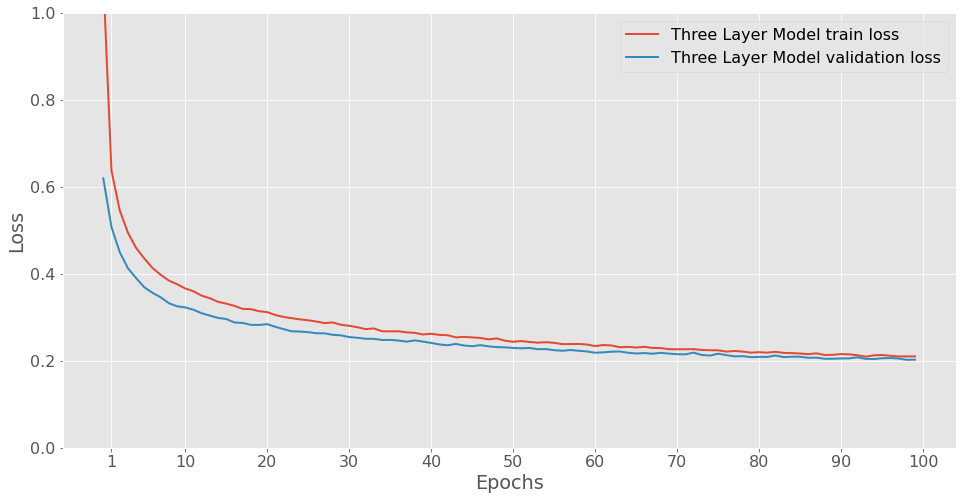

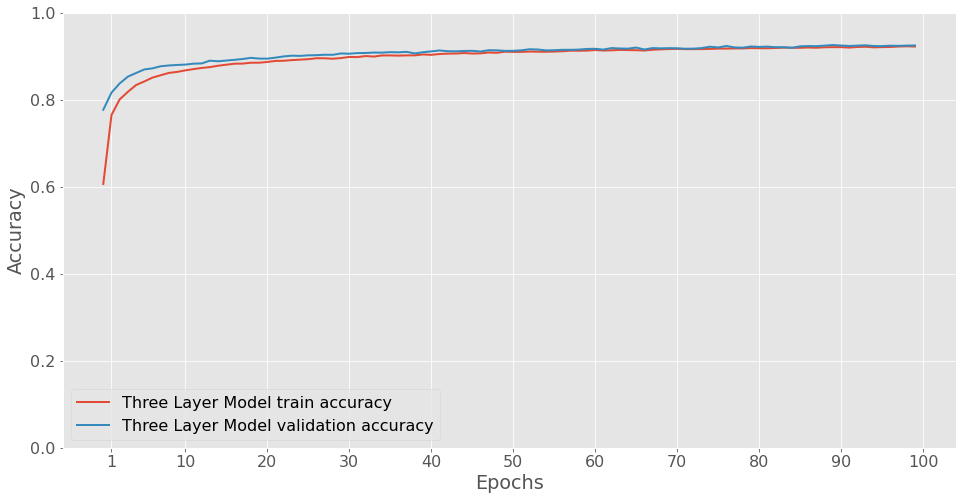

In [24]:
# Load the best weights
model_3.load_weights('./Checkpoints/best_weights_Third_CNN_Model.h5')

# Evaluate model with best weights on test data and show all the results.
score = model_3.evaluate(x_test, y_test, verbose=0)

# Print results
print_results(hs_3, score)

# Plot train and validation error per epoch.
plot_history(hs={'Three Layer Model': hs_3}, epochs=100, metric='loss')
plot_history(hs={'Three Layer Model': hs_3}, epochs=100, metric='accuracy')

##### 4.3.4 Predictions

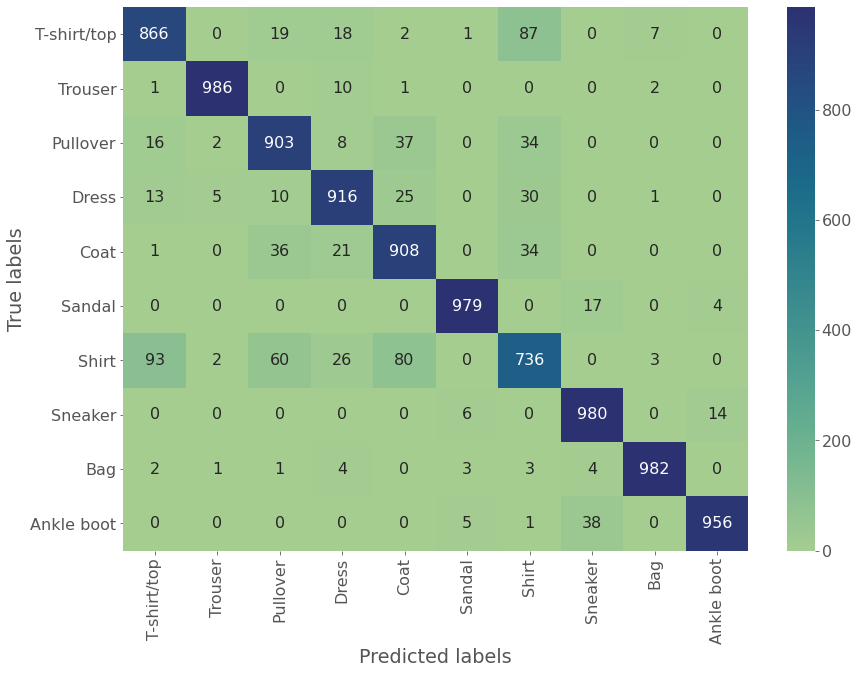

In [25]:
# Predict labels for test data
y_pred = model_3.predict(x_test, verbose = 0)

# Heatmap plot
plot_cm(y_pred, y_test)

# Delete model
clean_up(model_3)

##### *Remarks*

- In **epoch 99**, Model 3 attains its minimum validation loss. The plot suggests that the loss remains relatively stable over 100 epochs, indicating a potential opportunity to extend training for this model.

- The model achieves an accuracy of **92.1%**, which is a definite improvement from the previous models.

- The TP of all categories have increased, especially for Shirts.

#### 4.4 **CNN classifier 4 - Model 4**

> **Convolution layers:** Two <br>
> **Dense layer:** One <br>
> **Activation function:** Relu and Softmax(output) <br>
> **Dropout:** 0.2 <br>
> **Loss function:** Categorical Cross Entropy <br>
> **Optimizer:** Adam, Learning Rate = 0.0002 <br>

##### 4.4.1 Creation

In [26]:
# Set seed for reproducibility
np.random.seed(99)
tf.random.set_seed(999)

# Define the input shape
input_shape = (28, 28, 1)

# Create a sequential model
model_2_1 = Sequential(name="Two_Layer_WD_CNN")

# Add the input layer to the model
model_2_1.add(Input(shape=input_shape, name='Input'))

# Add the first convolutional layer
model_2_1.add(Conv2D(
    filters=8 * 2,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    dilation_rate=(1, 1),
    kernel_initializer='he_uniform',
    activation='relu',
    name='Conv2D-1'
))

# Add the first max pooling layer
model_2_1.add(MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2),
    padding='same',
    name='MaxPool2D-1'
))

# Add the first dropout layer
model_2_1.add(Dropout(rate=0.2, name='Dropout-1'))

# Add the second convolutional layer
model_2_1.add(Conv2D(
    filters=8 * 4,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    dilation_rate=(1, 1),
    kernel_initializer='he_uniform',
    activation='relu',
    name='Conv2D-2'
))

# Add the second max pooling layer
model_2_1.add(MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2),
    padding='same',
    name='MaxPool2D-2'
))

# Add the second dropout layer
model_2_1.add(Dropout(rate=0.2, name='Dropout-2'))

# Add flatten layer
model_2_1.add(Flatten(name='Flatten'))

# Add a dense layer
model_2_1.add(Dense(units=256, activation='relu'))

# Add dropout layer for dense layer
model_2_1.add(Dropout(rate=0.2, name='Dense_Dropout'))

# Add the output layer
model_2_1.add(Dense(units=10, activation='softmax', name='Output'))

# Display model summary
model_2_1.summary()

Model: "Two_Layer_WD_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D-1 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 MaxPool2D-1 (MaxPooling2D)  (None, 14, 14, 16)        0         
                                                                 
 Dropout-1 (Dropout)         (None, 14, 14, 16)        0         
                                                                 
 Conv2D-2 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 MaxPool2D-2 (MaxPooling2D)  (None, 7, 7, 32)          0         
                                                                 
 Dropout-2 (Dropout)         (None, 7, 7, 32)          0         
                                                                 
 Flatten (Flatten)           (None, 1568)         

##### 4.4.2 Training

In [27]:
callbacks = [ModelCheckpoint(filepath='./Checkpoints/best_weights_WD_CNN_Model.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True)]

optimizer = Adam(learning_rate = 0.0002)

model_2_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

hs_2_1 = model_2_1.fit(
        x=x_train,
        y=y_train,
        validation_split=0.1,
        epochs=100,
        verbose=1,
        callbacks=[callbacks],
        batch_size=128
    )

Epoch 1/100
422/422 [==============================] - 11s 25ms/step - loss: 0.7638 - accuracy: 0.7171 - val_loss: 0.4855 - val_accuracy: 0.8282
Epoch 2/100
422/422 [==============================] - 10s 24ms/step - loss: 0.4971 - accuracy: 0.8171 - val_loss: 0.4178 - val_accuracy: 0.8515
Epoch 3/100
422/422 [==============================] - 10s 24ms/step - loss: 0.4404 - accuracy: 0.8409 - val_loss: 0.3739 - val_accuracy: 0.8653
Epoch 4/100
422/422 [==============================] - 10s 24ms/step - loss: 0.4037 - accuracy: 0.8511 - val_loss: 0.3517 - val_accuracy: 0.8733
Epoch 5/100
422/422 [==============================] - 11s 25ms/step - loss: 0.3757 - accuracy: 0.8629 - val_loss: 0.3352 - val_accuracy: 0.8773
Epoch 6/100
422/422 [==============================] - 11s 26ms/step - loss: 0.3584 - accuracy: 0.8691 - val_loss: 0.3314 - val_accuracy: 0.8768
Epoch 7/100
422/422 [==============================] - 11s 26ms/step - loss: 0.3426 - accuracy: 0.8750 - val_loss: 0.3060 - val_ac

##### 4.4.3 Evaluation

Best Epoch:  51
---
Train Loss     : 0.14546
Validation Loss: 0.19690
Test Loss      : 0.21677
---
Train Accuracy     : 0.94561
Validation Accuracy: 0.93183
Test Accuracy      : 0.92460



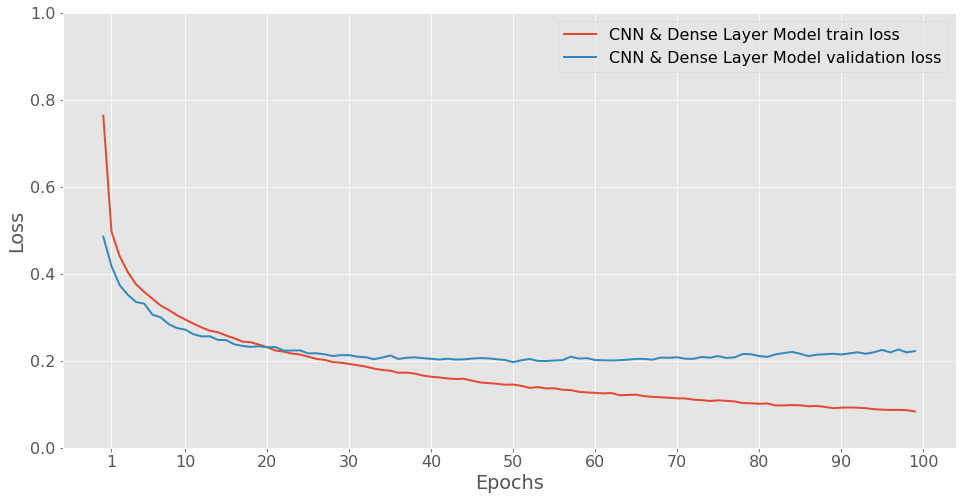

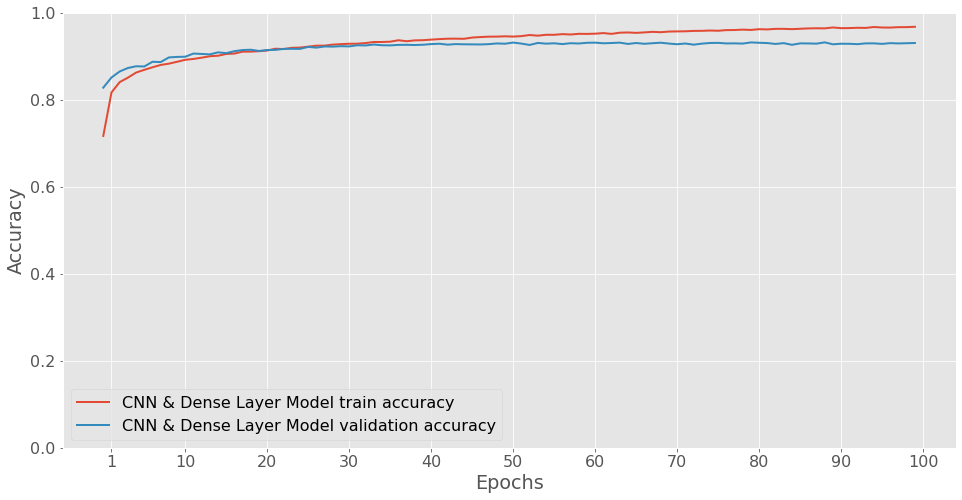

In [29]:
# Load the best weights
model_2_1.load_weights('./Checkpoints/best_weights_WD_CNN_Model.h5')

# Evaluate model with best weights on test data and show all the results.
score = model_2_1.evaluate(x_test, y_test, verbose=0)

# Print results
print_results(hs_2_1, score)

# Plot train and validation error per epoch.
plot_history(hs={'CNN & Dense Layer Model': hs_2_1}, epochs=100, metric='loss')
plot_history(hs={'CNN & Dense Layer Model': hs_2_1}, epochs=100, metric='accuracy')

##### 4.4.4 Predictions

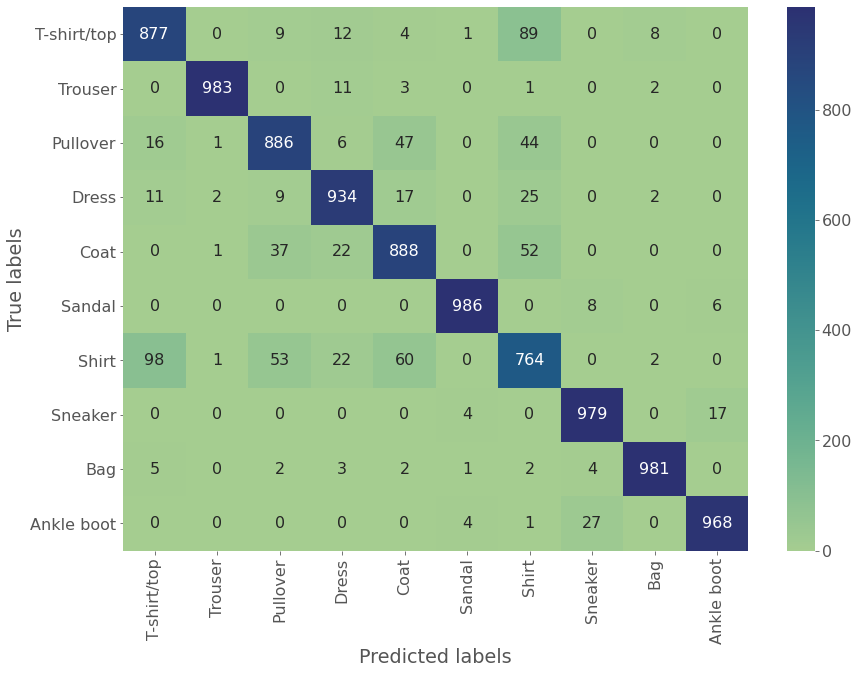

In [30]:
# Predict labels for test data
y_pred = model_2_1.predict(x_test, verbose = 0)

# Heatmap plot
plot_cm(y_pred, y_test)

# Delete model
clean_up(model_2_1)

##### *Remarks*

- Here we added an additional dence layer betweeen the final pooling and the output layer.

- We attained the minimum validation loss in **epoch 51**. However, as the training progresses, the model begins to exhibit signs of overfitting.

- The model achieves an accuracy of **92.4%**, which is a small improvement from the previous model. 

- The TP of all categories have increased, especially for Shirts.